# SigLIP VLM — 6-Class Chest X-Ray Classification

Dataset: COVID-19, Bacterial Pneumonia, Normal, Tuberculosis (6 classes)

In [27]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from math import sqrt
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
# Install transformers if not available: pip install transformers
from transformers import SiglipVisionModel, SiglipImageProcessor

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
dataset = Path(r"/kaggle/input/")

# Recursively search for a folder by name anywhere under base
def find_folder(base, folder_name, max_depth=5):
    base = Path(base)
    def _search(current, depth):
        if depth == 0:
            return None
        try:
            for entry in current.iterdir():
                if not entry.is_dir():
                    continue
                if entry.name == folder_name:
                    return entry
                result = _search(entry, depth - 1)
                if result:
                    return result
        except PermissionError:
            pass
        return None
    result = _search(base, max_depth)
    if result is None:
        raise FileNotFoundError(
            f"Could not find folder '{folder_name}' anywhere under {base}"
        )
    return result

covid_19   = find_folder(dataset, "COVID-19_Radiography_Dataset")
chest_xray = find_folder(dataset, "chest_xray")
tb_chest   = find_folder(dataset, "TB_Chest_Radiography_Database")

print(f"covid_19   = {covid_19}")
print(f"chest_xray = {chest_xray}")
print(f"tb_chest   = {tb_chest}")

covid_19   = /kaggle/input/datasets/tawsifurrahman/covid19-radiography-database/COVID-19_Radiography_Dataset
chest_xray = /kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray
tb_chest   = /kaggle/input/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database


## Data Loading

In [30]:
class_mapping = defaultdict(list)

def append_file_names(directory, cls_name):
    """Append image file names from a directory to the class mapping."""
    directory = Path(directory)
    for f_name in os.listdir(directory):
        if f_name.lower().endswith((".jpeg", ".jpg", ".png")):
            class_mapping[cls_name].append(str(directory / f_name))

# COVID-19 dataset: each subfolder (COVID, Lung_Opacity, Normal, Viral Pneumonia)
# has an 'images' subdirectory
for covid19_class in [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]:
    images_dir = covid_19 / covid19_class / 'images'
    if images_dir.exists():
        append_file_names(images_dir, covid19_class)
    else:
        # Some versions store images directly in the class folder
        append_file_names(covid_19 / covid19_class, covid19_class)

# Chest X-Ray dataset: only Bacterial Pneumonia (bacteria keyword in filename)
pneumonia_dirs = [chest_xray / "train" / "PNEUMONIA",
                  chest_xray / "test"  / "PNEUMONIA",
                  chest_xray / "val"   / "PNEUMONIA"]
for source_dir in pneumonia_dirs:
    if not source_dir.exists():
        print(f"Skipping (not found): {source_dir}")
        continue
    for filename in os.listdir(source_dir):
        if filename.lower().endswith((".jpeg", ".jpg", ".png")):
            if "bacteria" in filename.lower():
                class_mapping["Bacterial Pneumonia"].append(str(source_dir / filename))

# TB dataset
tb_dir = tb_chest / "Tuberculosis"
if tb_dir.exists():
    append_file_names(tb_dir, "Tuberculosis")
else:
    print(f"TB directory not found: {tb_dir}")

print("Classes found:", list(class_mapping.keys()))
print("Counts:", {k: len(v) for k, v in class_mapping.items()})

class_names = list(class_mapping.keys())
image_paths = []
labels = []

for class_name, file_paths in class_mapping.items():
    for file_path in tqdm(file_paths, desc=f"Processing {class_name}"):
        image_paths.append(file_path)
        labels.append(class_name)

Classes found: ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID', 'Bacterial Pneumonia', 'Tuberculosis']
Counts: {'Normal': 10192, 'Lung_Opacity': 6012, 'Viral Pneumonia': 1345, 'COVID': 3616, 'Bacterial Pneumonia': 2780, 'Tuberculosis': 700}


Processing Tuberculosis: 100%|██████████| 700/700 [00:00<00:00, 2798868.26it/s]


## Train/Val/Test Split

In [31]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

remaining_paths, test_paths, remaining_labels, test_labels = train_test_split(
    image_paths, labels_encoded, test_size=0.1, random_state=42, stratify=labels_encoded
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    remaining_paths, remaining_labels, test_size=0.1111, random_state=42, stratify=remaining_labels
)

total_samples = len(labels_encoded)
print(f"Train: {len(train_paths)} ({len(train_paths)/total_samples*100:.2f}%)")
print(f"Val:   {len(val_paths)} ({len(val_paths)/total_samples*100:.2f}%)")
print(f"Test:  {len(test_paths)} ({len(test_paths)/total_samples*100:.2f}%)")

Train: 19715 (80.00%)
Val:   2465 (10.00%)
Test:  2465 (10.00%)


## Dataset & DataLoaders

In [32]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_labels, transform=None):
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(img)
        transformed_img = self.transform(pil_img)
        label = self.img_labels[index]
        return transformed_img, label

In [33]:
BATCH_SIZE = 16
MODEL_NAME = "google/siglip-base-patch16-224"

# SigLIP requires specific pixel normalization — use the HF processor inside the dataset
siglip_processor = SiglipImageProcessor.from_pretrained(MODEL_NAME)

class SigLIPDataset(Dataset):
    """Dataset that applies the SiglipImageProcessor normalization."""
    def __init__(self, img_paths, img_labels):
        self.img_paths = img_paths
        self.img_labels = img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(img)
        # Processor handles resize to 224x224 + normalization
        inputs = siglip_processor(images=pil_img, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)  # (3, 224, 224)
        label = self.img_labels[index]
        return pixel_values, label

train_dataset = SigLIPDataset(train_paths, train_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataset = SigLIPDataset(val_paths, val_labels)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
test_dataset = SigLIPDataset(test_paths, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

## SigLIP VLM Model

In [34]:
MODEL_NAME = "google/siglip-base-patch16-224"

class SigLIPClassifier(nn.Module):
    """Wraps SiglipVisionModel with a classification head."""
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.vision_model = SiglipVisionModel.from_pretrained(model_name)
        hidden_size = self.vision_model.config.hidden_size  # 768 for base
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.vision_model(pixel_values=pixel_values)
        # Use the pooled output (mean of patch tokens)
        pooled = outputs.last_hidden_state.mean(dim=1)  # (B, hidden_size)
        logits = self.classifier(pooled)
        return logits

model = SigLIPClassifier(MODEL_NAME, num_classes)
model = model.to(device)
summary(model, input_size=(1, 3, 224, 224))

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

SiglipVisionModel LOAD REPORT from: google/siglip-base-patch16-224
Key                                                          | Status     |  | 
-------------------------------------------------------------+------------+--+-
text_model.embeddings.position_embedding.weight              | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.layer_norm1.weight        | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.layer_norm1.bias          | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc2.bias              | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.layer_norm2.bias          | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.q_proj.bias     | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.q_proj.weight   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc1.bias              | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.layer_norm2.weight        | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.v_proj.b

Layer (type:depth-idx)                                       Output Shape              Param #
SigLIPClassifier                                             [1, 6]                    --
├─SiglipVisionModel: 1-1                                     [1, 768]                  --
│    └─SiglipVisionTransformer: 2-1                          [1, 768]                  --
│    │    └─SiglipVisionEmbeddings: 3-1                      [1, 196, 768]             741,120
│    │    └─SiglipEncoder: 3-2                               [1, 196, 768]             85,054,464
│    │    └─LayerNorm: 3-3                                   [1, 196, 768]             1,536
│    │    └─SiglipMultiheadAttentionPoolingHead: 3-4         [1, 768]                  7,087,104
├─Linear: 1-2                                                [1, 6]                    4,614
Total params: 92,888,838
Trainable params: 92,888,838
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 205.69
Input size (MB): 0.60
Forward/backward 

## Metrics Function

In [35]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)
    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)
    auc_scores = []
    for class_idx in range(y_pred.shape[1]):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)
    auc_avg = np.mean(auc_scores)
    return {
        "loss": loss, "accuracy": accuracy, "precision": precision,
        "recall": recall, "f1_score": f1, "specificity": specificity,
        "sensitivity": sensitivity, "mcc": mcc, "auc": auc_avg,
    }

## Training

In [36]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {m: [] for m in metric_names}
val_metrics_history = {m: [] for m in metric_names}

num_epochs = 25
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for data, targets in tqdm(train_loader, desc=f"Training - Epoch [{epoch+1}/{num_epochs}]"):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    total_training_time += end_time - start_time

    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    for m in metric_names:
        train_metrics_history[m].append(train_metrics[m])
    line = "Train - " + ", ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])
    print(line)

    # Validation
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    val_start = time.time()
    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc=f"Validation - Epoch [{epoch+1}/{num_epochs}]"):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    total_validation_time += time.time() - val_start

    average_loss = total_loss / len(val_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    for m in metric_names:
        val_metrics_history[m].append(val_metrics[m])
    line = "Val   - " + ", ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()])
    print(line)

    scheduler.step()

print(f"\nTotal Training Time: {str(timedelta(seconds=int(total_training_time)))}")
print(f"Total Validation Time: {str(timedelta(seconds=int(total_validation_time)))}")

Training - Epoch [1/25]: 100%|██████████| 1233/1233 [06:28<00:00,  3.18it/s]


Train - loss: 0.2455, accuracy: 0.9144, precision: 0.9147, recall: 0.9144, f1_score: 0.9141, specificity: 0.9658, sensitivity: 0.9948, mcc: 0.8825, auc: 0.9804


Validation - Epoch [1/25]: 100%|██████████| 155/155 [00:20<00:00,  7.48it/s]


Val   - loss: 0.1527, accuracy: 0.9497, precision: 0.9497, recall: 0.9497, f1_score: 0.9496, specificity: 0.9964, sensitivity: 0.9950, mcc: 0.9312, auc: 0.9948


Training - Epoch [2/25]: 100%|██████████| 1233/1233 [06:28<00:00,  3.17it/s]


Train - loss: 0.1052, accuracy: 0.9637, precision: 0.9637, recall: 0.9637, f1_score: 0.9636, specificity: 0.9910, sensitivity: 0.9991, mcc: 0.9503, auc: 0.9954


Validation - Epoch [2/25]: 100%|██████████| 155/155 [00:15<00:00,  9.85it/s]


Val   - loss: 0.1498, accuracy: 0.9517, precision: 0.9531, recall: 0.9517, f1_score: 0.9515, specificity: 0.9784, sensitivity: 0.9995, mcc: 0.9344, auc: 0.9955


Training - Epoch [3/25]: 100%|██████████| 1233/1233 [06:28<00:00,  3.17it/s]


Train - loss: 0.0653, accuracy: 0.9777, precision: 0.9777, recall: 0.9777, f1_score: 0.9777, specificity: 0.9924, sensitivity: 0.9990, mcc: 0.9695, auc: 0.9979


Validation - Epoch [3/25]: 100%|██████████| 155/155 [00:15<00:00,  9.90it/s]


Val   - loss: 0.1405, accuracy: 0.9611, precision: 0.9612, recall: 0.9611, f1_score: 0.9609, specificity: 1.0000, sensitivity: 0.9995, mcc: 0.9468, auc: 0.9960


Training - Epoch [4/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.17it/s]


Train - loss: 0.0458, accuracy: 0.9846, precision: 0.9846, recall: 0.9846, f1_score: 0.9846, specificity: 0.9919, sensitivity: 0.9990, mcc: 0.9790, auc: 0.9989


Validation - Epoch [4/25]: 100%|██████████| 155/155 [00:15<00:00,  9.87it/s]


Val   - loss: 0.1462, accuracy: 0.9606, precision: 0.9608, recall: 0.9606, f1_score: 0.9607, specificity: 0.9748, sensitivity: 1.0000, mcc: 0.9463, auc: 0.9960


Training - Epoch [5/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.17it/s]


Train - loss: 0.0328, accuracy: 0.9886, precision: 0.9886, recall: 0.9886, f1_score: 0.9886, specificity: 0.9955, sensitivity: 0.9994, mcc: 0.9845, auc: 0.9995


Validation - Epoch [5/25]: 100%|██████████| 155/155 [00:15<00:00,  9.89it/s]


Val   - loss: 0.1716, accuracy: 0.9533, precision: 0.9549, recall: 0.9533, f1_score: 0.9530, specificity: 1.0000, sensitivity: 0.9995, mcc: 0.9367, auc: 0.9957


Training - Epoch [6/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.17it/s]


Train - loss: 0.0224, accuracy: 0.9925, precision: 0.9925, recall: 0.9925, f1_score: 0.9925, specificity: 1.0000, sensitivity: 0.9999, mcc: 0.9898, auc: 0.9997


Validation - Epoch [6/25]: 100%|██████████| 155/155 [00:15<00:00,  9.83it/s]


Val   - loss: 0.1500, accuracy: 0.9594, precision: 0.9598, recall: 0.9594, f1_score: 0.9594, specificity: 0.9892, sensitivity: 1.0000, mcc: 0.9445, auc: 0.9963


Training - Epoch [7/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.17it/s]


Train - loss: 0.0177, accuracy: 0.9947, precision: 0.9947, recall: 0.9947, f1_score: 0.9947, specificity: 0.9964, sensitivity: 0.9995, mcc: 0.9927, auc: 0.9999


Validation - Epoch [7/25]: 100%|██████████| 155/155 [00:15<00:00,  9.93it/s]


Val   - loss: 0.1554, accuracy: 0.9623, precision: 0.9623, recall: 0.9623, f1_score: 0.9623, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9484, auc: 0.9964


Training - Epoch [8/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.16it/s]


Train - loss: 0.0190, accuracy: 0.9932, precision: 0.9932, recall: 0.9932, f1_score: 0.9932, specificity: 0.9946, sensitivity: 0.9997, mcc: 0.9906, auc: 0.9998


Validation - Epoch [8/25]: 100%|██████████| 155/155 [00:15<00:00,  9.90it/s]


Val   - loss: 0.1976, accuracy: 0.9611, precision: 0.9612, recall: 0.9611, f1_score: 0.9609, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9468, auc: 0.9963


Training - Epoch [9/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.16it/s]


Train - loss: 0.0212, accuracy: 0.9935, precision: 0.9935, recall: 0.9935, f1_score: 0.9935, specificity: 0.9924, sensitivity: 0.9992, mcc: 0.9911, auc: 0.9997


Validation - Epoch [9/25]: 100%|██████████| 155/155 [00:15<00:00,  9.93it/s]


Val   - loss: 0.2240, accuracy: 0.9554, precision: 0.9560, recall: 0.9554, f1_score: 0.9551, specificity: 0.9676, sensitivity: 1.0000, mcc: 0.9392, auc: 0.9950


Training - Epoch [10/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.16it/s]


Train - loss: 0.0222, accuracy: 0.9930, precision: 0.9930, recall: 0.9930, f1_score: 0.9930, specificity: 0.9960, sensitivity: 0.9995, mcc: 0.9904, auc: 0.9997


Validation - Epoch [10/25]: 100%|██████████| 155/155 [00:15<00:00,  9.76it/s]


Val   - loss: 0.1885, accuracy: 0.9627, precision: 0.9635, recall: 0.9627, f1_score: 0.9625, specificity: 0.9964, sensitivity: 0.9995, mcc: 0.9492, auc: 0.9963


Training - Epoch [11/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.16it/s]


Train - loss: 0.0142, accuracy: 0.9957, precision: 0.9957, recall: 0.9957, f1_score: 0.9957, specificity: 0.9969, sensitivity: 0.9996, mcc: 0.9942, auc: 0.9999


Validation - Epoch [11/25]: 100%|██████████| 155/155 [00:15<00:00,  9.92it/s]


Val   - loss: 0.1843, accuracy: 0.9594, precision: 0.9598, recall: 0.9594, f1_score: 0.9593, specificity: 0.9928, sensitivity: 0.9995, mcc: 0.9446, auc: 0.9967


Training - Epoch [12/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.16it/s]


Train - loss: 0.0151, accuracy: 0.9952, precision: 0.9952, recall: 0.9952, f1_score: 0.9952, specificity: 0.9960, sensitivity: 0.9997, mcc: 0.9934, auc: 0.9999


Validation - Epoch [12/25]: 100%|██████████| 155/155 [00:15<00:00,  9.94it/s]


Val   - loss: 0.1548, accuracy: 0.9590, precision: 0.9598, recall: 0.9590, f1_score: 0.9590, specificity: 0.9892, sensitivity: 1.0000, mcc: 0.9440, auc: 0.9966


Training - Epoch [13/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.17it/s]


Train - loss: 0.0136, accuracy: 0.9961, precision: 0.9961, recall: 0.9961, f1_score: 0.9961, specificity: 0.9987, sensitivity: 0.9999, mcc: 0.9947, auc: 0.9999


Validation - Epoch [13/25]: 100%|██████████| 155/155 [00:15<00:00,  9.87it/s]


Val   - loss: 0.2020, accuracy: 0.9566, precision: 0.9573, recall: 0.9566, f1_score: 0.9562, specificity: 0.9856, sensitivity: 1.0000, mcc: 0.9410, auc: 0.9959


Training - Epoch [14/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.16it/s]


Train - loss: 0.0098, accuracy: 0.9964, precision: 0.9964, recall: 0.9964, f1_score: 0.9964, specificity: 0.9973, sensitivity: 0.9995, mcc: 0.9951, auc: 0.9999


Validation - Epoch [14/25]: 100%|██████████| 155/155 [00:15<00:00,  9.91it/s]


Val   - loss: 0.2369, accuracy: 0.9606, precision: 0.9611, recall: 0.9606, f1_score: 0.9605, specificity: 0.9892, sensitivity: 1.0000, mcc: 0.9463, auc: 0.9959


Training - Epoch [15/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.17it/s]


Train - loss: 0.0158, accuracy: 0.9954, precision: 0.9954, recall: 0.9954, f1_score: 0.9954, specificity: 0.9951, sensitivity: 0.9994, mcc: 0.9937, auc: 0.9999


Validation - Epoch [15/25]: 100%|██████████| 155/155 [00:15<00:00,  9.82it/s]


Val   - loss: 0.1973, accuracy: 0.9542, precision: 0.9544, recall: 0.9542, f1_score: 0.9542, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9374, auc: 0.9957


Training - Epoch [16/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.17it/s]


Train - loss: 0.0115, accuracy: 0.9965, precision: 0.9965, recall: 0.9965, f1_score: 0.9965, specificity: 0.9978, sensitivity: 0.9995, mcc: 0.9952, auc: 0.9998


Validation - Epoch [16/25]: 100%|██████████| 155/155 [00:15<00:00,  9.95it/s]


Val   - loss: 0.2110, accuracy: 0.9566, precision: 0.9570, recall: 0.9566, f1_score: 0.9563, specificity: 0.9856, sensitivity: 0.9995, mcc: 0.9409, auc: 0.9961


Training - Epoch [17/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.16it/s]


Train - loss: 0.0104, accuracy: 0.9965, precision: 0.9965, recall: 0.9965, f1_score: 0.9965, specificity: 0.9964, sensitivity: 0.9997, mcc: 0.9952, auc: 1.0000


Validation - Epoch [17/25]: 100%|██████████| 155/155 [00:15<00:00,  9.89it/s]


Val   - loss: 0.2293, accuracy: 0.9505, precision: 0.9513, recall: 0.9505, f1_score: 0.9501, specificity: 1.0000, sensitivity: 0.9973, mcc: 0.9326, auc: 0.9949


Training - Epoch [18/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.17it/s]


Train - loss: 0.0098, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: 0.9978, sensitivity: 0.9998, mcc: 0.9954, auc: 0.9999


Validation - Epoch [18/25]: 100%|██████████| 155/155 [00:15<00:00,  9.89it/s]


Val   - loss: 0.2170, accuracy: 0.9558, precision: 0.9558, recall: 0.9558, f1_score: 0.9558, specificity: 0.9964, sensitivity: 0.9991, mcc: 0.9395, auc: 0.9962


Training - Epoch [19/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.17it/s]


Train - loss: 0.0070, accuracy: 0.9978, precision: 0.9978, recall: 0.9978, f1_score: 0.9978, specificity: 1.0000, sensitivity: 0.9999, mcc: 0.9970, auc: 1.0000


Validation - Epoch [19/25]: 100%|██████████| 155/155 [00:15<00:00,  9.88it/s]


Val   - loss: 0.1954, accuracy: 0.9598, precision: 0.9602, recall: 0.9598, f1_score: 0.9598, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9451, auc: 0.9962


Training - Epoch [20/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.17it/s]


Train - loss: 0.0127, accuracy: 0.9962, precision: 0.9962, recall: 0.9962, f1_score: 0.9962, specificity: 0.9960, sensitivity: 0.9996, mcc: 0.9948, auc: 0.9999


Validation - Epoch [20/25]: 100%|██████████| 155/155 [00:15<00:00,  9.90it/s]


Val   - loss: 0.2170, accuracy: 0.9611, precision: 0.9617, recall: 0.9611, f1_score: 0.9608, specificity: 1.0000, sensitivity: 0.9995, mcc: 0.9469, auc: 0.9961


Training - Epoch [21/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.17it/s]


Train - loss: 0.0084, accuracy: 0.9973, precision: 0.9973, recall: 0.9973, f1_score: 0.9973, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9963, auc: 0.9999


Validation - Epoch [21/25]: 100%|██████████| 155/155 [00:15<00:00,  9.81it/s]


Val   - loss: 0.2630, accuracy: 0.9574, precision: 0.9581, recall: 0.9574, f1_score: 0.9572, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9419, auc: 0.9959


Training - Epoch [22/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.17it/s]


Train - loss: 0.0099, accuracy: 0.9972, precision: 0.9972, recall: 0.9972, f1_score: 0.9972, specificity: 0.9951, sensitivity: 0.9995, mcc: 0.9961, auc: 0.9999


Validation - Epoch [22/25]: 100%|██████████| 155/155 [00:15<00:00,  9.91it/s]


Val   - loss: 0.2733, accuracy: 0.9505, precision: 0.9517, recall: 0.9505, f1_score: 0.9504, specificity: 1.0000, sensitivity: 0.9995, mcc: 0.9324, auc: 0.9956


Training - Epoch [23/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.17it/s]


Train - loss: 0.0096, accuracy: 0.9970, precision: 0.9970, recall: 0.9970, f1_score: 0.9970, specificity: 0.9987, sensitivity: 0.9998, mcc: 0.9958, auc: 0.9999


Validation - Epoch [23/25]: 100%|██████████| 155/155 [00:15<00:00,  9.89it/s]


Val   - loss: 0.2543, accuracy: 0.9574, precision: 0.9578, recall: 0.9574, f1_score: 0.9573, specificity: 0.9820, sensitivity: 1.0000, mcc: 0.9418, auc: 0.9950


Training - Epoch [24/25]: 100%|██████████| 1233/1233 [06:29<00:00,  3.17it/s]


Train - loss: 0.0093, accuracy: 0.9969, precision: 0.9969, recall: 0.9969, f1_score: 0.9969, specificity: 0.9964, sensitivity: 0.9995, mcc: 0.9958, auc: 0.9999


Validation - Epoch [24/25]: 100%|██████████| 155/155 [00:15<00:00,  9.86it/s]


Val   - loss: 0.1917, accuracy: 0.9562, precision: 0.9566, recall: 0.9562, f1_score: 0.9558, specificity: 0.9964, sensitivity: 1.0000, mcc: 0.9404, auc: 0.9951


Training - Epoch [25/25]: 100%|██████████| 1233/1233 [06:27<00:00,  3.18it/s]


Train - loss: 0.0069, accuracy: 0.9980, precision: 0.9980, recall: 0.9980, f1_score: 0.9980, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9973, auc: 1.0000


Validation - Epoch [25/25]: 100%|██████████| 155/155 [00:15<00:00,  9.90it/s]

Val   - loss: 0.2234, accuracy: 0.9627, precision: 0.9627, recall: 0.9627, f1_score: 0.9627, specificity: 0.9928, sensitivity: 1.0000, mcc: 0.9490, auc: 0.9953

Total Training Time: 2:42:12
Total Validation Time: 0:06:37


## Plot Metrics

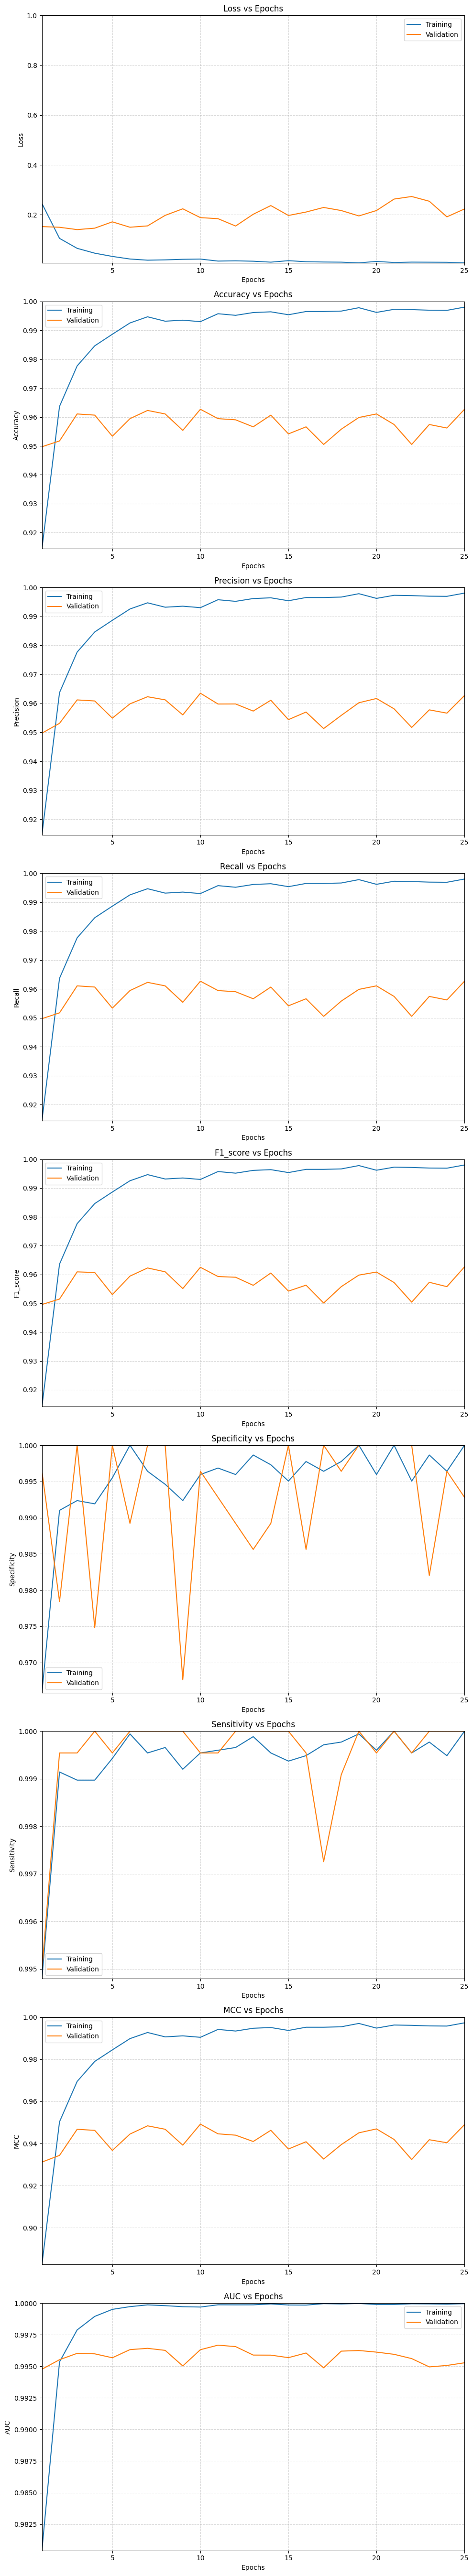

In [37]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])
    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    rng = range(1, num_epochs + 1)
    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]
        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")
        label = metric_name.upper() if metric_name in ("auc", "mcc") else metric_name.capitalize()
        ax.set_ylabel(label)
        ax.set_title(f"{label} vs Epochs")
        max_m = max(max(train_metric), max(val_metric))
        min_m = min(min(train_metric), min(val_metric))
        ax.set_ylim(min_m if min_m < 0 or max_m > 1 else min_m, math.ceil(max_m))
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)
    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

## Test Evaluation

In [38]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, targets in tqdm(test_loader, desc="Testing Model"):
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
print("Test Metrics:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

Testing Model: 100%|██████████| 155/155 [00:20<00:00,  7.51it/s]

Test Metrics:
  loss: 0.2393
  accuracy: 0.9521
  precision: 0.9524
  recall: 0.9521
  f1_score: 0.9522
  specificity: 0.9820
  sensitivity: 1.0000
  mcc: 0.9346
  auc: 0.9952


## Classification Report & Confusion Matrix

                     precision    recall  f1-score   support

Bacterial Pneumonia     1.0000    0.9820    0.9909       278
              COVID     0.9863    0.9917    0.9890       362
       Lung_Opacity     0.9171    0.9201    0.9186       601
             Normal     0.9487    0.9431    0.9459      1019
       Tuberculosis     1.0000    0.9714    0.9855        70
    Viral Pneumonia     0.9236    0.9852    0.9534       135

           accuracy                         0.9521      2465
          macro avg     0.9626    0.9656    0.9639      2465
       weighted avg     0.9524    0.9521    0.9522      2465

There were 118 errors in 2465 tests for an accuracy of  95.21%


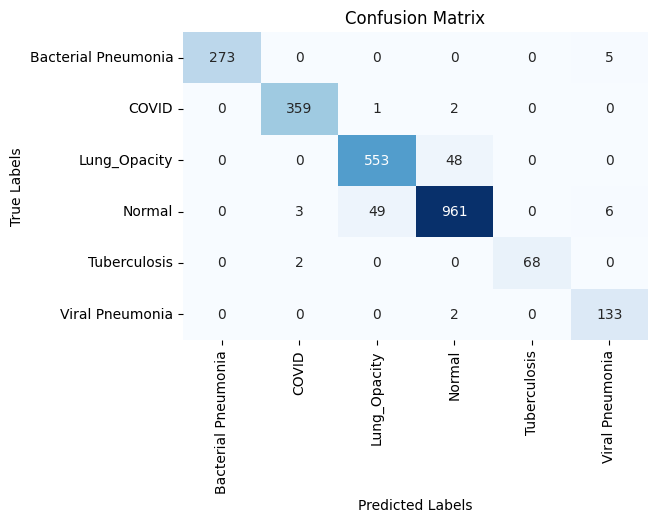

In [39]:
true_labels = np.array(all_targets).astype(int)
predicted_labels = np.argmax(np.array(all_predictions), axis=1).astype(int)
report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)
print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}%')

conf_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    conf_matrix[t, p] += 1
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()